Embedding

In [1]:
# vector_all_cele: {name: vector}
# list_celebrity: list of all 318 celebrity
# stats_dict_spase: dictionary of all following data, if follow 1, else 0


In [2]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import collections
import random
from scipy import stats
import math

In [3]:
# file_path = '/Users/lvenbo/Desktop/twitter_data'
file_path = '/Users/lvenbo/Desktop/twitter_data/'
save_path = '/Users/lvenbo/Desktop/twitter_result_new/'
following_data = pd.read_csv(file_path +'adj_matrix_US.csv')
# 318 celebrities, 301537 users
# type: # pandas.core.frame.DataFrame
following_data = following_data.set_index('Unnamed: 0')
list_celebrity = list(following_data.columns)


In [4]:
# stats_dict_spase = following_data.to_dict()
stats_dict_spase = np.load(file_path + 'stats_dict_spase.npy', allow_pickle = True).item()

# np.save(file_path + 'stats_dict_spase.npy', stats_dict_spase)

# filter out the 0s
stats_dict_dense = collections.defaultdict(dict)
for key in stats_dict_spase:
    stats_dict_dense[key] = {x:y for x,y in stats_dict_spase[key].items() if y!=0}

key_dict = collections.defaultdict(dict)
for mini_dict in stats_dict_dense:
    k_list = list(stats_dict_dense[mini_dict].keys())
    key_dict[mini_dict] = k_list

sentences = [[key, value] for key in key_dict for value in key_dict[key]] #


In [5]:
# number of celebrity
length_following = [len(stats_dict_dense[key]) for key in list(stats_dict_dense.keys())]
print(len(length_following))
print(sum(length_following)/318) # 平均每个celebrity有8642个followers
print(len(stats_dict_spase['nytimes']))

318
8641.761006289309
301537


In [6]:
def embedding_preprocess(vectors):
    vectors = vectors.divide(np.linalg.norm(vectors.values, axis=1), axis='rows')
    return vectors

def model_to_dict(model, list_celebrity):
    dict_re = collections.defaultdict(dict)
    for i in range(len(list_celebrity)):
        dict_re[list_celebrity[i]] = model.wv[list_celebrity[i]]
    return dict_re

In [10]:
# from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self, threshold=600000):
        self.epoch = 0
        self.threshold = threshold
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.losses.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            self.losses.append(loss-self.loss_previous_step)
        #
        # if self.epoch > 10 and (self.losses[-1] -self.losses[-2]) > 0 and (self.losses[-2] -self.losses[-3])>0 and loss < self.threshold:
        #     print('Training stopped as loss is below the threshold and not improving.')
        #     model.stop_training = True  # Stop training

        self.epoch += 1
        self.loss_previous_step = loss

from gensim.models.callbacks import CallbackAny2Vec

class EarlyStoppingCallback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch and save the best model based on a monitored metric.
    """

    def __init__(self, monitor='val_loss', threshold=300000, patience=10 ,save_path = None):
        self.epoch = 0
        self.monitor = monitor
        self.threshold = threshold
        self.losses = []
        self.patience = patience
        # self.min_delta = min_delta
        self.wait = 0
        self.best_metric = float('inf')
        self.save_path = save_path

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            loss_now = loss
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.losses.append(loss)
        else:
            loss_now = loss - self.loss_previous_step
            print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
            self.losses.append(loss_now)
            print(self.losses)
        if self.epoch > self.patience and  loss_now < self.threshold and (self.losses[-1] > self.losses[-2] > self.losses[-3] or ((abs(self.losses[-1] - self.losses[-2]) <= 0.008*loss_now and abs(self.losses[-2] - self.losses[-3]) <= 0.008*loss_now))):
            print('Training stopped because loss is below threshold and not improving.')
            raise StopTrainingException  # Raise custom exception to stop training

        # Save the model if it improves on the monitored metric
        if self.monitor_loss(loss_now):
            # print('new loss',loss_now)
            # print(self.best_metric)
            if loss_now < self.best_metric:
                self.best_metric = loss_now
                if self.save_path:
                    model.save(self.save_path)  # Save the best model

        self.epoch += 1
        self.loss_previous_step = loss

    def monitor_loss(self, current_loss):
        if self.monitor == 'val_loss':
            return True  # Monitor validation loss
        # Add additional conditions for other monitored metrics if needed
        return False


class StopTrainingException(Exception):
    pass



In [11]:
sentences_reorder = [[key, value] for key in key_dict for value in key_dict[key]]
# # eg. [['BarackObama', 'us298496'], ['BarackObama', 'us57798'], ['BarackObama', 'us194743'],
random.seed(47)
random.shuffle(sentences_reorder) # shuffle the data


In [14]:
epoch = 10
path_save_2 = '/Users/lvenbo/Desktop/' + 'model_reorder.model'
# path_save_2 = save_path +'model'+str(epoch) + '/model_reorder.model'

In [15]:

model_2_reorder = Word2Vec(sentences_reorder, sg=1, negative= 20, vector_size=50, window=2, workers=4, alpha = 0.025, sample = 0.001, min_count = 0, epochs = epoch, compute_loss=True, callbacks=[EarlyStoppingCallback(save_path=path_save_2)])

Loss after epoch 0: 6804579.5
Loss after epoch 1: 3217286.5
[6804579.5, 3217286.5]
Loss after epoch 2: 1959853.0
[6804579.5, 3217286.5, 1959853.0]
Loss after epoch 3: 1813047.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0]
Loss after epoch 4: 1734432.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0, 1734432.0]
Loss after epoch 5: 1567068.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0, 1734432.0, 1567068.0]
Loss after epoch 6: 1240764.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0, 1734432.0, 1567068.0, 1240764.0]
Loss after epoch 7: 1189446.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0, 1734432.0, 1567068.0, 1240764.0, 1189446.0]
Loss after epoch 8: 1126154.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0, 1734432.0, 1567068.0, 1240764.0, 1189446.0, 1126154.0]
Loss after epoch 9: 1070610.0
[6804579.5, 3217286.5, 1959853.0, 1813047.0, 1734432.0, 1567068.0, 1240764.0, 1189446.0, 1126154.0, 1070610.0]


# load and test model

In [17]:

model_2_reorder = Word2Vec.load(path_save_2)
dict_cele_vector_reorder = model_to_dict(model_2_reorder, list_celebrity)

re_df_reorder = pd.DataFrame.from_dict(dict_cele_vector_reorder, orient='index')
re_df_reorder = embedding_preprocess(re_df_reorder)

In [26]:
def score_embedding(vectors, dimensions):

    columns = {}

    for name, data in dimensions:
        columns[name] = np.dot(vectors.values, data["vector"] / np.linalg.norm(data["vector"]))

    return pd.DataFrame(columns, index=vectors.index)

def cosine_similarity(vectors):
    # normalize vectors
    vectors = vectors.divide(np.linalg.norm(vectors.values, axis=1), axis='rows')
    # dot
    sims = np.dot(vectors.values, vectors.values.T)

    return sims
def normalise(original_container):
    # original_container = np.array(original_container)
    maxx, meann = np.amax(original_container), np.mean(original_container)
    new_containter = (original_container-meann)/abs(maxx)
    return new_containter

class DimenGenerator:

    def __init__(self, vectors):
        self.vectors = vectors

        self.name_mapping = {name.lower(): name for name in self.vectors.index}

        comm_names = list(self.vectors.index)
        cosine_sims = cosine_similarity(self.vectors)

        # Find each community's nearest neighbours
        ranks = cosine_sims.argsort()
        ranks = ranks.argsort()


        nn_n = 10
        only_calculate_for = \
            (ranks > (len(comm_names) - nn_n - 2)) & \
            ~np.diag(np.ones(len(comm_names), dtype=bool))

        indices_to_calc = np.nonzero(only_calculate_for)

        index = []
        directions = []
        for i in range(0, len(indices_to_calc[0])):
            c1 = indices_to_calc[0][i]
            c2 = indices_to_calc[1][i]
            index.append((comm_names[c1], comm_names[c2])) # 10 closest people to every people
            directions.append(self.vectors.iloc[c2] - self.vectors.iloc[c1])
        # print(len(index))
        print(len(directions))

        print("%d valid directions, %d calculated." % (np.sum(only_calculate_for), len(directions)))
        self.directions_to_score = pd.DataFrame(index=pd.MultiIndex.from_tuples(index), data=directions)

    def generate_dimensions_from_seeds(self, seeds):
        return list(map(lambda x: self.generate_dimension_from_seeds([x]), seeds))

    def generate_dimension_from_seeds(self, seeds):

        seed_directions = self.vectors.loc[map(lambda x: x[1], seeds)].values - \
            self.vectors.loc[map(lambda x: x[0], seeds)].values

        seed_similarities = np.dot(self.directions_to_score, seed_directions.T)
        # print(seed_similarities.shape)
        seed_similarities = np.amax(seed_similarities, axis=1)

        directions = self.directions_to_score.iloc[np.flip(seed_similarities.T.argsort())]
        # print('directions')
        # print(directions)


        # How many directions to take?
        num_directions = 10

        # make directions unique subreddits (subreddit can only occur once)
        ban_list = [s for sd in seeds for s in sd]
        i = -1 # to filter out seed pairs
        while (i < len(directions)) and (i < (num_directions + 1)):
            ban_list.extend(directions.index[i])

            l0 = directions.index.get_level_values(0)
            l1 = directions.index.get_level_values(1)
            directions = directions[(np.arange(0, len(directions)) <= i) | ((~l0.isin(ban_list)) & (~l1.isin(ban_list)))]

            i += 1

        # Add seeds to the top
        directions = pd.concat([pd.DataFrame(seed_directions, index=seeds), directions])

        direction_group = directions.iloc[0:num_directions]
        print(direction_group) # (10*50)

        dimension = np.sum(direction_group.values, axis=0)

        return {
            "note": "generated from seed pairs",
            "seed": seeds,
            "vector": dimension,
            "left_comms": list(map(lambda x: x[0], direction_group.index)),
            "right_comms": list(map(lambda x: x[1], direction_group.index)),
        }
    def from_nearest_neighbour(self, seeds):
        """
        new way of finding dimensions:
        :param seeds: the chosen seed pair
        :return:
        """
        # get the seed elite1, seed elite 2's vector embedding
        print('start from nearest neighbour')
        left_vector = self.vectors.loc[map(lambda x: x[0], seeds)].values
        right_vector = self.vectors.loc[map(lambda x: x[1], seeds)].values
        seed_diff = right_vector-left_vector


        # get the seed elite1, seed elite 2's n nn's vector difference
        """   """
        left_vals = self.directions_to_score.loc[map(lambda x: x[0], seeds)].values
        right_vals = self.directions_to_score.loc[map(lambda x: x[1], seeds)].values
        # put them in the same narray
        values_leftright = np.vstack((left_vals, right_vals))
        # get the corresponding names for the ad's index
        index_left = [item for item in self.index if item[0] == seeds[0][0]]
        index_right = [item for item in self.index if item[0] == seeds[0][1]]
        index_leftright = index_left + index_right
        # create the df, index is the seed elite and its nn
        self.left_right = pd.DataFrame(index=pd.MultiIndex.from_tuples(index_leftright), data=values_leftright)
        # print('top 20s')
        # print(self.left_right)

        # calculate cos sim between the neighbours' difference between the elites
        cosine_sims_neighbours = cosine_similarity(self.left_right)

        # get the upper right corner of the square matrix, which contain all the cos sim
        rng = int(cosine_sims_neighbours.shape[0]/2)
        real_cosine_sim = cosine_sims_neighbours[:rng, -rng:]

        # chose the top half most similar(maximum value)
        # num_max = int(rng/2)
        num_max = 9
        selected_values = []  # To store the selected values
        used_rows = set()  # To keep track of used rows
        used_cols = set()
        list_rows = []
        list_cols = []
        for _ in range(num_max):
            max_value = -float('inf')
            max_row, max_col = None, None

            for row in range(real_cosine_sim.shape[0]):
                for col in range(real_cosine_sim.shape[1]):
                    if row not in used_rows and col not in used_cols:
                        if real_cosine_sim[row, col] > max_value:
                            max_value = real_cosine_sim[row, col]
                            max_row, max_col = row, col

            selected_values.append(max_value)
            used_rows.add(max_row)
            used_cols.add(max_col)
            list_rows.append(max_row)
            list_cols.append(max_col)

        leftt = [item[1] for item in index_left]
        rightt = [item[1] for item in index_right]
        index_list = []
        vector_list = []

        for item in zip(list_rows, list_cols):
            left_i = item[0]
            right_i = item[1]

            left_name = leftt[left_i]
            right_name = rightt[right_i]
            index_list.append((left_name, right_name))
            v = self.vectors.loc[right_name].values-self.vectors.loc[left_name].values
            vector_list.append(v)
        # directions = pd.concat([pd.DataFrame(seed_directions, index=seeds), directions])
        vector_list.append(seed_diff[0])
        index_list.append(seeds[0])
        direction_group = np.array(vector_list)
        print('direction_group.shape:',direction_group.shape)

        dimension = np.mean(vector_list, axis=0)
            # 添加index
        return {
            "note": "generated from seed pairs",
            "seed": seeds,
            "vector": dimension,
            "argument_directions": direction_group,
            "left_comms": [item[0] for item in index_list],
            "right_comms": [item[1] for item in index_list],
            "pairs": index_list
        }


# Generate dimension

In [19]:
dimen_generator_1_reorder = DimenGenerator(re_df_reorder)
dimen_names = ['partisan']

3180
3180 valid directions, 3180 calculated.


In [20]:
seed_pair_1 = ('TheDemocrats', 'Senate_GOPs')

dimension_1_reorder = dimen_generator_1_reorder.generate_dimensions_from_seeds([seed_pair_1])


                                      0         1         2         3   \
(TheDemocrats, Senate_GOPs)     0.009501  0.352820 -0.055639 -0.348936   
(JonHuntsman, SenJohnThune)    -0.140317 -0.081180 -0.085698 -0.162199   
(msnbc, FoxNews)               -0.382239  0.223646 -0.238860 -0.008957   
(clairecmc, JohnEnsign)         0.007423 -0.066296 -0.166671  0.052583   
(jaredpolis, RepMikeCoffman)   -0.073818  0.062116  0.097733 -0.138576   
(congressorg, WaysandMeansGOP)  0.075583 -0.031527 -0.109414 -0.236747   
(GovGaryJohnson, SenMikeLee)   -0.108140  0.176390  0.190888 -0.115606   
(elizabethforma, ScottBrownMA) -0.147374 -0.146960 -0.059858 -0.354011   
(JoeBiden, GabbyGiffords)      -0.093484  0.383257  0.194466 -0.044590   
(Obama2012, SenatorHagan)       0.106985 -0.159213 -0.098268 -0.301569   

                                      4         5         6         7   \
(TheDemocrats, Senate_GOPs)     0.177012  0.365929 -0.035390 -0.082017   
(JonHuntsman, SenJohnThune)     0.122

In [21]:

def dim_generate_from_pairs(pair,dimension_1):
    re_dimension = dimension_1.generate_dimensions_from_seeds([pair])
    # dimension2 = dimension_2.generate_dimensions_from_seeds([pair])
    return re_dimension

def generate_score_ranking(df, re_dimension):
    re_scores_csv = score_embedding(df, zip(['partisan'], re_dimension))

    pairs_list = []
    for name, dimen in zip(['partisan'], re_dimension):
        print("Dimension %s:" % name)
        print("\tSeed: %s" % dimen["seed"])
        print("\tFound seeds:")
        for c1, c2 in zip(dimen["left_comms"], dimen["right_comms"]):
            pairs_list.append([c1, c2])
            print("\t\t%s -> %s" % (c1, c2))

    re_scores_csv.index.name = 'elite'
    re_scores_rank = re_scores_csv.copy()
    re_scores_rank['rank'] = re_scores_rank.rank()

    # re_rank = re_scores_copy.rank()

    # re_scores_copy = re_scores_copy.sort_values(by='partisan')

    return re_scores_csv, re_scores_rank, pairs_list




# Score, ranking result

In [22]:

scores_1_reorder, rank_1_reorder, pairs_1_reorder = generate_score_ranking(re_df_reorder, dimension_1_reorder)


Dimension partisan:
	Seed: [('TheDemocrats', 'Senate_GOPs')]
	Found seeds:
		TheDemocrats -> Senate_GOPs
		JonHuntsman -> SenJohnThune
		msnbc -> FoxNews
		clairecmc -> JohnEnsign
		jaredpolis -> RepMikeCoffman
		congressorg -> WaysandMeansGOP
		GovGaryJohnson -> SenMikeLee
		elizabethforma -> ScottBrownMA
		JoeBiden -> GabbyGiffords
		Obama2012 -> SenatorHagan


In [23]:
rank_1_reorder

,partisan,rank
elite,,
BarackObama,-0.377301,6.0
nytimes,-0.098034,29.0
Schwarzenegger,0.047471,77.0
algore,-0.070840,36.0
maddow,-0.313074,8.0
...,...,...
McConnellPress,0.383150,183.0
RepJimMatheson,0.331291,166.0
SenJohnBarrasso,0.632001,308.0


In [24]:
def dict_to_vector(dict_input, dim, model):
    re_vector = np.empty([318, dim,])
    for i, key in enumerate(list_celebrity):
        arr_vector = model.wv[key]
        re_vector[i] = arr_vector
    return re_vector


In [25]:
vector_1_reorder = dict_to_vector(dict_cele_vector_reorder, 50, model_2_reorder)


# Visualise

In [101]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [102]:
def visualise_embedding(re_dict, model, dim_num, path):
    vect = dict_to_vector(re_dict, dim_num, model)

    pca = PCA(n_components=2)
    result = pca.fit_transform(vect)

    # 可视化展示
    pyplot.figure(figsize=(20, 20
                           ))
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list_celebrity
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    # pyplot.show()
    pyplot.savefig(save_path + path)

In [104]:
def visualise_embedding1D(re_dict, model, dim_num, path):
    vect = dict_to_vector(re_dict, dim_num, model)

    pca = PCA(n_components=1)
    result = pca.fit_transform(vect)

    # 可视化展示
    pyplot.figure(figsize=(200, 200
                           ))
    pyplot.scatter(result[:, 0],[1]*len(result))
    words = list_celebrity
    for i, word in enumerate(words):
        if i%2 == 0:
            pyplot.annotate(word, xy=(result[i, 0], 1.02))
        else:
            pyplot.annotate(word, xy=(result[i, 0], 0.98))
    # pyplot.show()
    pyplot.savefig(save_path + path)

In [105]:
# visualise_embedding1D(dict_cele_vector_epoch, model_1, 50, path = '/model'+str(epoch)+'/plot_1.png')

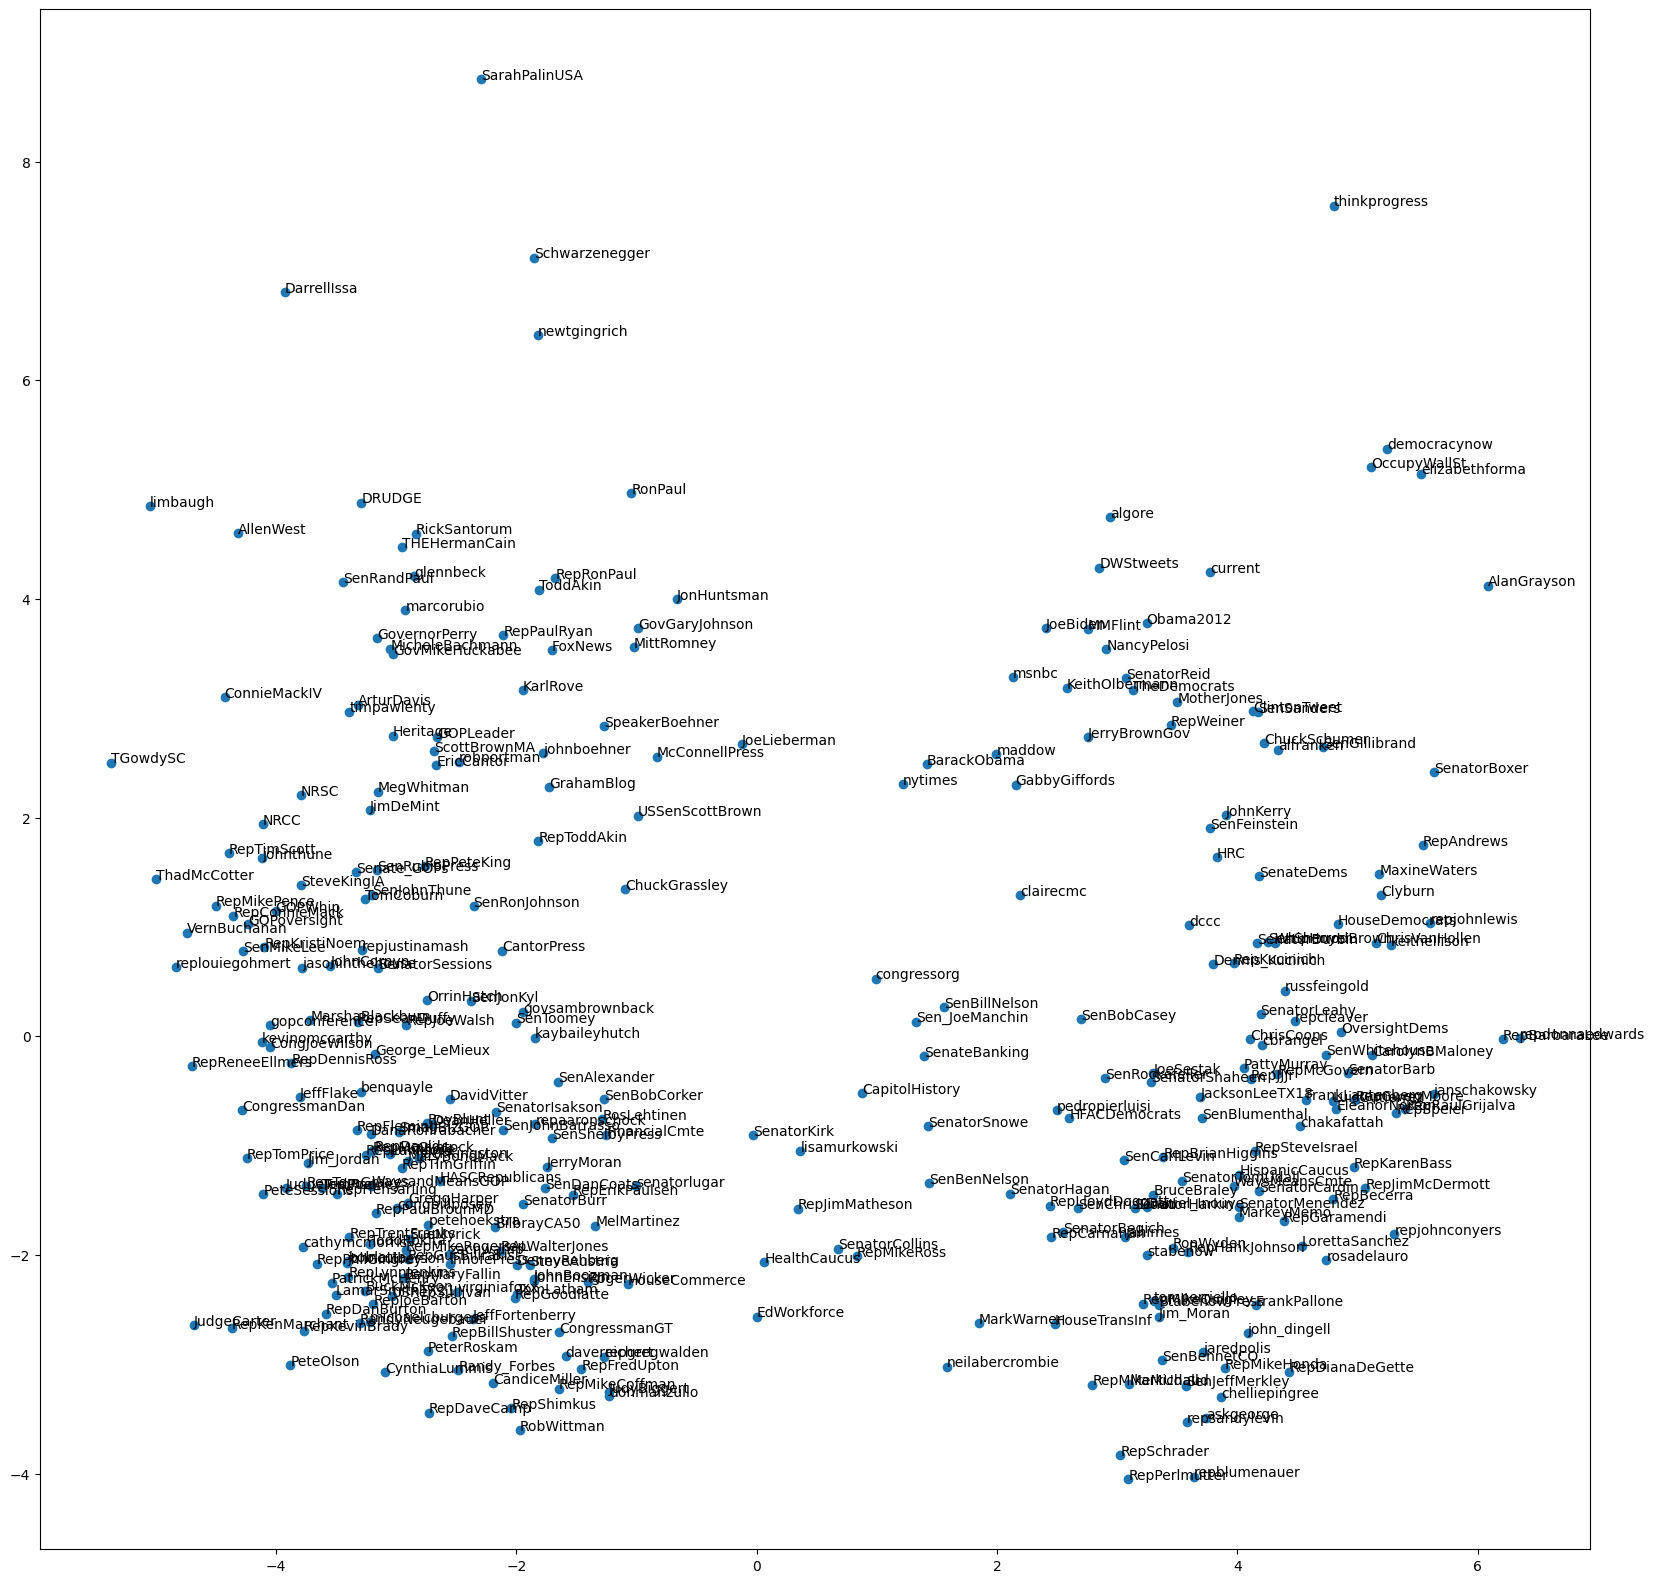

In [108]:
visualise_embedding(dict_cele_vector_reorder, model_2_reorder, 50, '/plot_2_2.png')


# Visualise pairs

In [109]:
def visual_pairs(re_dict, model, dim_num, list_10):
    left = [item[0] for item in list_10]
    right = [item[1] for item in list_10]

    vect = dict_to_vector(re_dict, dim_num, model)

    pca = PCA(n_components=2)
    result = pca.fit_transform(vect)

    pyplot.figure(figsize=(10, 10))
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list_celebrity
    for i, word in enumerate(words):
        if word in left:
            pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = 'blue')
        elif word in right:
            pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = 'red')
    # pyplot.show()



    # Add lines connecting pairs.
    for pair in list_10:
        point1 = result[words.index(pair[0])]
        point2 = result[words.index(pair[1])]
        pyplot.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-') # 'k-' means black color, straight line

    pyplot.show()


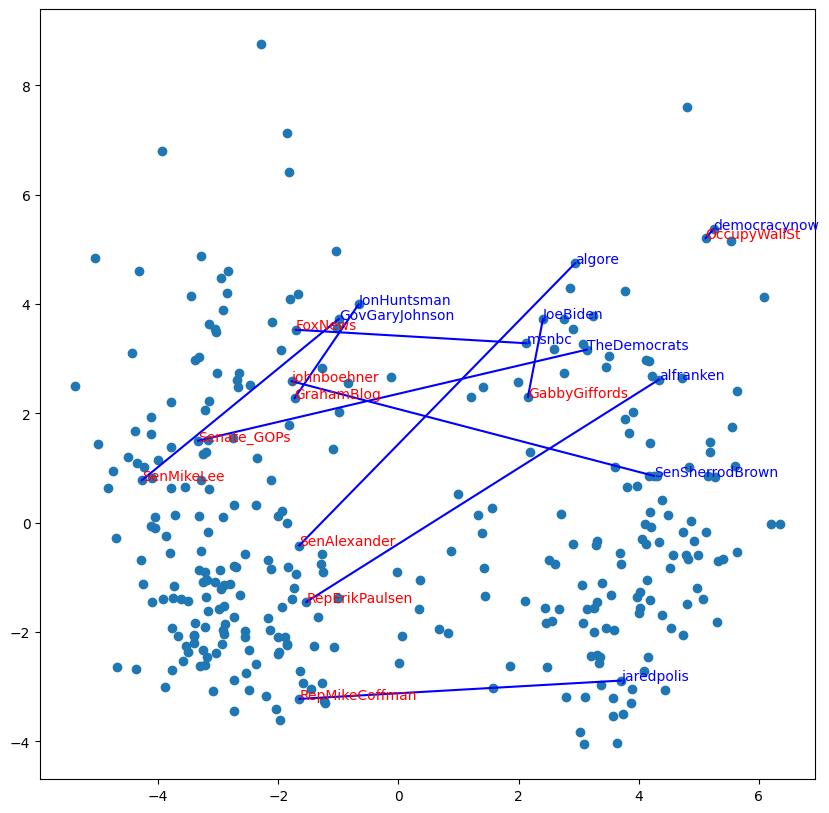

In [111]:
visual_pairs(dict_cele_vector_reorder, model_2_reorder, 50, pairs_1_reorder)
